In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
%load_ext Cython

In [3]:
%%cython
import numpy as np
cimport numpy as np
from numpy import dot
from libc.math cimport sqrt

DBL = np.double
ctypedef np.double_t DBL_C
INT = np.int
ctypedef np.int_t INT_C
cdef INT_C w, h

w, h = 200, 200 # Size of the screen in pixels

def normalize(np.ndarray[DBL_C, ndim=1] x):
    # This function normalizes a vector.
    x /= np.linalg.norm(x)
    return x

def intersect_sphere(np.ndarray[DBL_C, ndim=1] O, np.ndarray[DBL_C, ndim=1] D,
                     np.ndarray[DBL_C, ndim=1] S, DBL_C R):
    """ Return the distance from O to the intersection
    of the ray (O, D) and the sphere (S, R), or
    +inf if there is no intersection.
    O and S are 3D points, D(direction) is a 
    normalized vector, R is a scalar.
    """
    cdef DBL_C a, b, c, disc, disSqrt, q, t0, t1
    cdef np.ndarray[DBL_C, ndim=1] OS
    
    a = dot(D, D)
    OS = O - S
    b = 2 * dot(D, OS)
    c = dot(OS, OS) - R * R
    disc = b*b - 4*a*c
    
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

def trace_ray(np.ndarray[DBL_C, ndim=1] O, np.ndarray[DBL_C, ndim=1] D,
               np.ndarray[DBL_C, ndim=1] position,
               np.ndarray[DBL_C, ndim=1] color,
               np.ndarray[DBL_C, ndim=1] L,
               np.ndarray[DBL_C, ndim=1] color_light):
        
    cdef DBL_C t
    cdef np.ndarray[DBL_C, ndim=1] M, N, toL, toO, col
    
    # Find first point of intersection with the scene.
    t = intersect_sphere(O, D, position, radius)
    # No intersection?
    if t == np.inf:
        return
    # Find the point of intersection on the object.
    M = O + D * t
    N = normalize(M - position)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Ambient light.
    col = ambient * np.ones(3)
    # Lambert shading (diffuse).
    col += diffuse * max(dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col += specular_c * color_light * \
        max(dot(N, normalize(toL + toO)), 0) \
           ** specular_k
    return col

def run():
    cdef np.ndarray[DBL_C, ndim=3] img
    img = np.zeros((h, w, 3))
    cdef INT_C i, j
    cdef DBL_C x, y
    cdef np.ndarray[DBL_C, ndim=1] O, Q, D, col, position, color, L, color_light

    # Sphere properties.
    position = np.array([0., 0., 1.])
    color = np.array([0., 0., 1.])
    L = np.array([5., 5., -10.])
    color_light = np.ones(3)
        
    # Camera.
    O = np.array([0., 0., -1.])  # Position.
    Q = np.array([0., 0., 0.])  # Pointing to.
        
    # Loop through all pixels.
    for i, x in enumerate(np.linspace(-1., 1., w)):
        for j, y in enumerate(np.linspace(-1., 1., h)):
            # Position of the pixel.
            Q[0], Q[1] = x, y
            # Direction of the ray going through the optical center.
            D = normalize(Q - O)
            # Launch the ray and get the color of the pixel.
            col = trace_ray(O, D, position, color, L, color_light)
            if col is None:
                continue
            img[h - j - 1, i, :] = np.clip(col, 0, 1)
    return img

cdef DBL_C radius, ambient, diffuse, specular_k, specular_c

# Sphere and light properties.
radius = 1.
diffuse = 1.
specular_c = 1.
specular_k = 50.
ambient = .05

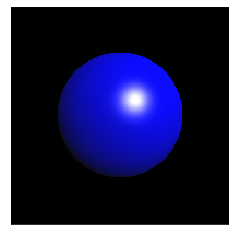

In [6]:
img = run()
plt.imshow(img);
plt.xticks([]); plt.yticks([]);

In [7]:
%timeit -n1 -r1 run()

1.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


There is a speed up of about 2x, but we can do better.

## Take 2
Rewrite `normalize` in pure C.

In [8]:
%%cython
import numpy as np
cimport numpy as np
from numpy import dot
from libc.math cimport sqrt

DBL = np.double
ctypedef np.double_t DBL_C
INT = np.int
ctypedef np.int_t INT_C
cdef INT_C w, h

w, h = 200, 200 # Size of the screen in pixels.

# normalize is now a pure C function that does not make use NumPy for the computations
cdef normalize(np.ndarray[DBL_C, ndim=1] x):
    cdef DBL_C n
    n = sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2]) 
    x[0] /= n
    x[1] /= n
    x[2] /= n
    return x

def intersect_sphere(np.ndarray[DBL_C, ndim=1] O, np.ndarray[DBL_C, ndim=1] D, 
                     np.ndarray[DBL_C, ndim=1] S, DBL_C R):
    # Return the distance from O to the intersection 
    # of the ray (O, D) with the sphere (S, R), or 
    # +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a 
    # normalized vector, R is a scalar.
    
    cdef DBL_C a, b, c, disc, distSqrt, q, t0, t1
    cdef np.ndarray[DBL_C, ndim=1] OS
    
    a = dot(D, D)
    OS = O - S
    b = 2 * dot(D, OS)
    c = dot(OS, OS) - R*R
    disc = b*b - 4*a*c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 \
            else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

def trace_ray(np.ndarray[DBL_C, ndim=1] O, np.ndarray[DBL_C, ndim=1] D,
               np.ndarray[DBL_C, ndim=1] position,
               np.ndarray[DBL_C, ndim=1] color,
               np.ndarray[DBL_C, ndim=1] L,
               np.ndarray[DBL_C, ndim=1] color_light):
        
    cdef DBL_C t
    cdef np.ndarray[DBL_C, ndim=1] M, N, toL, toO, col
    
    # Find first point of intersection with the scene.
    t = intersect_sphere(O, D, position, radius)
    # No intersection?
    if t == np.inf:
        return
    # Find the point of intersection on the object.
    M = O + D * t
    N = normalize(M - position)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Ambient light.
    col = ambient * np.ones(3)
    # Lambert shading (diffuse).
    col += diffuse * max(dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col += specular_c * color_light * \
        max(dot(N, normalize(toL + toO)), 0) \
           ** specular_k
    return col

def run():
    cdef np.ndarray[DBL_C, ndim=3] img
    img = np.zeros((h, w, 3))
    cdef INT_C i, j
    cdef DBL_C x, y
    cdef np.ndarray[DBL_C, ndim=1] O, Q, D, col, position, color, L, color_light

    # Sphere properties.
    position = np.array([0., 0., 1.])
    color = np.array([0., 0., 1.])
    L = np.array([5., 5., -10.])
    color_light = np.ones(3)
        
    # Camera.
    O = np.array([0., 0., -1.])  # Position.
    Q = np.array([0., 0., 0.])  # Pointing to.
        
    # Loop through all pixels.
    for i, x in enumerate(np.linspace(-1., 1., w)):
        for j, y in enumerate(np.linspace(-1., 1., h)):
            # Position of the pixel.
            Q[0], Q[1] = x, y
            # Direction of the ray going through the optical center.
            D = normalize(Q - O)
            # Launch the ray and get the color of the pixel.
            col = trace_ray(O, D, position, color, L, color_light)
            if col is None:
                continue
            img[h - j - 1, i, :] = np.clip(col, 0, 1)
    return img

cdef DBL_C radius, ambient, diffuse, specular_k, specular_c

# Sphere and light properties.
radius = 1.
diffuse = 1.
specular_c = 1.
specular_k = 50.
ambient = .05

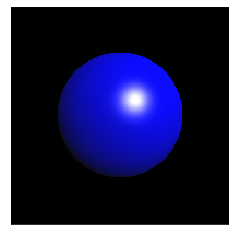

In [9]:
img = run()
plt.imshow(img);
plt.xticks([]); plt.yticks([]);

In [10]:
%timeit -n1 -r1 run()

902 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We have halved the time again.